# Chapter 1, figures 1 and 2

The notebooks included in this repository are intended to show you how raw data was transformed into a particular table or graph.

The graphs may not look exactly like the published versions, because those were created in a different language (R). But they should be substantively equivalent.

## Figure 1.1

Graphing the frequency of color vocabulary in a subset of volumes.

The list of words we count as "color words" is contained in ```colors.txt.``` The list of volumes to be plotted is contained in ```prestigeset.csv```. That file actually contains a range of volumes, not all of which are particularly prestigious! Its name comes from the fact that it does record, in one column, *whether* the volume was included in a list of prestigious/reviewed volumes. (For more on the source of that list, see chapter 3).

#### Counting the frequency of color words

The code below counts words and creates a data file, ```colorfic.csv```.

In [2]:
#!/usr/bin/env python3

import csv, os, sys
from collections import Counter

# import utils
sys.path.append('../../lib')

import SonicScrewdriver as utils
import FileCabinet as filecab

# start by loading the hard seeds

colors = set()

with open('../lexicons/colors.txt', encoding = 'utf-8') as f:
    for line in f:
        colors.add(line.strip())

logistic = dict()
realclass = dict()
titles = dict()
dates = dict()

with open('../metadata/prestigeset.csv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        logistic[row['volid']] = float(row['logistic'])
        realclass[row['volid']] = row['prestige']
        titles[row['volid']] = row['title']
        dates[row['volid']] = int(row['dateused'])

sourcedir = '../sourcefiles/'
documents = filecab.get_wordcounts(sourcedir, '.tsv', set(logistic))

outrows = []

for docid, doc in documents.items():
    if docid not in logistic:
        continue
    else:
        allwords = 1
        colorct = 0

        for word, count in doc.items():
            allwords += count
            if word in colors:
                colorct += count

        outline = [docid, realclass[docid], logistic[docid], (colorct/allwords), dates[docid], titles[docid]]
        outrows.append(outline)

fields = ['docid', 'class', 'logistic', 'colors', 'date', 'title']
with open('../plotdata/colorfic.csv', mode = 'w', encoding = 'utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(fields)
    for row in outrows:
        writer.writerow(row)

#### Loading the data we just created as a data frame

It would have been more elegant to create a data frame in memory, instead of writing the data to file as an intermediary step, and then reading it back in.

But that's not how I originally wrote the process, and rewriting several years of code for pure elegance would be a bit extravagant. So having written the data out, let's read it back in.

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

We can take a look at what is actually in the data frame.

In [10]:
color_df = pd.read_csv('../plotdata/colorfic.csv')
color_df.head()

,docid,class,logistic,colors,date,title
0,dul1.ark+=13960=t3611qj21,0,0.763305,0.000589,1709,Secret memoirs and manners of several persons ...
1,pst.000005236749,0,0.720563,0.000475,1778,The adventures of Gil Blas of Santillane
2,mdp.49015002138908,1,0.804597,0.001687,1910,The collected works of William Morris;
3,mdp.39015008180096,0,0.786933,0.000197,1781,Moral tales
4,nyp.33433081970190,1,0.889924,0.000871,1843,Moral tales


#### Visualizing the data

I'll use color to distinguish reviewed volumes from those not marked as reviewed in elite journals. (We don't actually know that they *weren't* ever reviewed.)

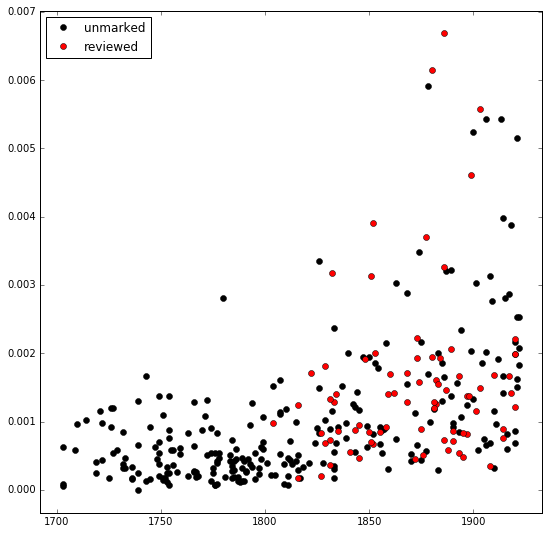

In [20]:
groups = color_df.groupby('class')
groupnames = {0: 'unmarked', 1: 'reviewed'}
groupcolors = {0: 'k', 1: 'r'}
fig, ax = plt.subplots(figsize = (9, 9))

ax.margins(0.05)
for code, group in groups:
    ax.plot(group.date, group.colors, marker='o', linestyle='', ms=6, color = groupcolors[code], label=groupnames[code])
ax.legend(numpoints = 1, loc = 'upper left')

plt.show()

#### other analysis, not in the book

Is there any difference between the frequency of color words in reviewed volumes and others? Let's focus on the volumes after 1800.

In [28]:
post1800 = color_df[color_df.date > 1800]
groups = post1800.groupby('class')
groups.aggregate(np.mean)

,logistic,colors,date
class,,,
0,0.764169,0.001441,1865.076336
1,0.783950,0.001564,1870.368421


I guess there is a really slight difference in the "colors" column. Reviewed works refer to colors a little more often. (Ignore the "logistic" column for now, it's inherited from a different process.) But is the difference in frequency of color words significant?

In [29]:
from scipy.stats import ttest_ind
ttest_ind(color_df[color_df['class'] == 1].colors, color_df[(color_df['class'] == 0) & (color_df['date'] > 1800)].colors, equal_var = False)

Ttest_indResult(statistic=0.68968816275016087, pvalue=0.49146510616036954)

No. That's not a significant result; there doesn't seem to be any meaningful difference between reviewed and unreviewed books, at least not at this scale of analysis.

## Figure 1.2

Now let's calculate the frequency of Stanford "hard seeds" in biography and fiction, aggregating by year.

#### count the "hard seeds"

In [31]:
stanford = set()

with open('../lexicons/stanford.csv', encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        if row['class'] == 'hard':
            stanford.add(row['word'])

sourcedir = '../sourcefiles/'

pairedpaths = filecab.get_pairedpaths(sourcedir, '.tsv')

docids = [x[0] for x in pairedpaths]

wordcounts = filecab.get_wordcounts(sourcedir, '.tsv', docids)

metapath = '../metadata/allgenremeta.csv'

genredict = dict()
datedict = dict()
with open(metapath, encoding = 'utf-8') as f:
    reader = csv.DictReader(f)
    for row in reader:
        date = int(row['firstpub'])
        genre = row['genretags']
        docid = row['docid']
        if date not in datedict:
            datedict[date] = []
        datedict[date].append(docid)
        genredict[docid] = genre

possible_genres = {'poe', 'fic', 'bio'}
allcounts = dict()
hardseedcounts = dict()
for genre in possible_genres:
    allcounts[genre] = Counter()
    hardseedcounts[genre] = Counter()

for i in range(1700,2000):
    if i in datedict:
        candidates = datedict[i]
        for anid in candidates:
            genre = genredict[anid]
            if anid not in wordcounts:
                print('error')
                continue
            else:
                for word, count in wordcounts[anid].items():
                    allcounts[genre][i] += count
                    if word in stanford:
                        hardseedcounts[genre][i] += count

with open('../plotdata/hardaverages.csv', mode = 'w', encoding = 'utf-8') as f:
    f.write('genre,year,hardpct\n')
    for genre in possible_genres:
        for i in range(1700,2000):
            if i in allcounts[genre]:
                pct = hardseedcounts[genre][i] / (allcounts[genre][i] + 1)
                f.write(genre + ',' + str(i) + ',' + str(pct) + '\n')



#### look at the data we created

In [32]:
hard_df = pd.read_csv('../plotdata/hardaverages.csv')
hard_df.head()

,genre,year,hardpct
0,bio,1700,0.018422
1,bio,1701,0.018594
2,bio,1702,0.020629
3,bio,1703,0.021265
4,bio,1704,0.026992


#### now plot the yearly averages for biography and fiction

We actually have the averages for poetry too, in this dataset, but we're not going to plot them, because it would be visually confusing in b/w (in print).

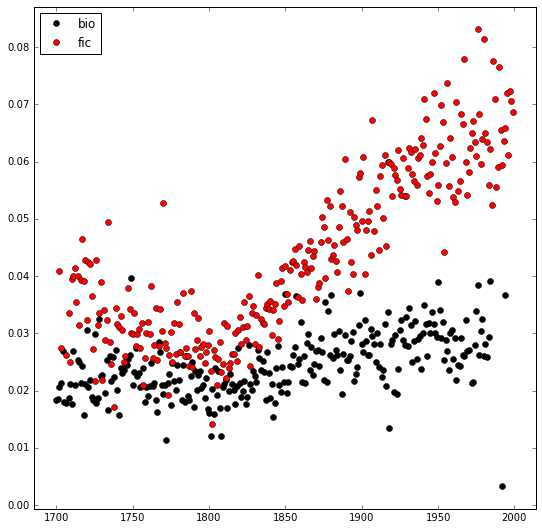

In [37]:
groups = hard_df.groupby('genre')
groupcolors = {'bio': 'k', 'fic': 'r', 'poe': 'g'}
fig, ax = plt.subplots(figsize = (9, 9))

ax.margins(0.05)
for code, group in groups:
    if code == 'poe':
        continue
    ax.plot(group.year, group.hardpct, marker='o', linestyle='', ms=6, color = groupcolors[code], label=code)
ax.legend(numpoints = 1, loc = 'upper left')

plt.show()